In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils import generate_data_object_synthetic

In [2]:
parameters = {
    "hidden_dims": [16, 8],
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 10000,
    "learning_rate": 0.005,
    "weight_decay": 0,
    "dropout": 0.4,
    "early_stopping": 200,
    "n_splits": 3,
    "device": "cuda",
    "done": False,
    "batch_size":128
    }

In [3]:
from IPython.utils import io

n_students_per_task_list = list(range(5,200, 10))

#n_students_per_task_list = [2**i for i in n_students_per_task_list]

scores = []

for n_student_per_task in tqdm(n_students_per_task_list):
    # print(n_student_per_task)
    with io.capture_output() as captured:
        data = generate_data_object_synthetic(
            # n_students = 200,
            # n_tasks = 3400,
            n_students = 250,
            n_tasks = 800,
            n_student_per_task = n_student_per_task,
            probabilistic = False)

        output_dict = perform_cross_validation(data, parameters)
        score = 0
        for fold_n in range(parameters["n_splits"]):
            score += output_dict[f"Balanced Accuracy_{fold_n}_test"]
        score = score / parameters["n_splits"]
        scores.append(score)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [1:25:33<00:00, 256.67s/it]


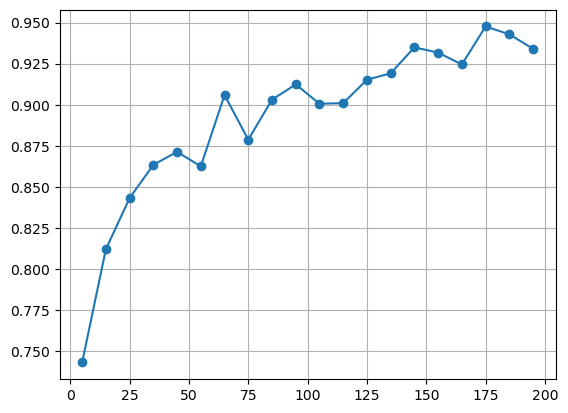

In [4]:
import matplotlib.pyplot as plt

plt.plot(n_students_per_task_list, scores,marker="o")
# plt.loglog()
plt.grid()
# plt.xscale("log")
plt.show()